In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import torch
from matplotlib import pyplot as plt

from neuroginius.atlas import Atlas

from cogpred.utils.configuration import get_config
from cogpred.utils.naming import make_run_path
from cogpred.loading import TSFetcher, make_training_data
from cogpred.plotting import plot_ts
from cogpred.features import make_features, generate_single_sub

WIN_SIZE = 24
torch.manual_seed(1234)
np.random.seed(1234)

config = get_config()
conn_dir = config["connectivity_matrices"]

k=3
labels = pd.read_csv(f"data/cluster_{k}_labels.csv", index_col=0)
ATLAS = "schaefer200"

run_path = make_run_path(config["output_dir"], k=k, feat="series", experimental=True, atlas=ATLAS)
os.makedirs(run_path, exist_ok=True)

In [2]:
# TS from DMN only should be fun
tspath = Path("/georges/memento/BIDS/derivatives/schaeffer200_merged_phenotypes")
atlas = Atlas.from_name("schaefer200")
fetcher = TSFetcher(tspath)

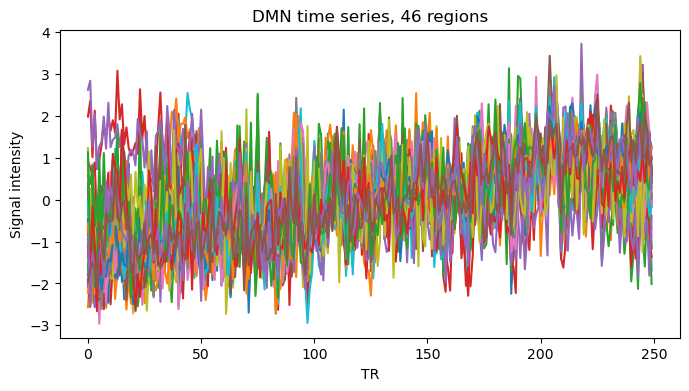

In [3]:
dmn_indexer = np.where(np.array(atlas.macro_labels) == "Default", True, False)

plot_ts(fetcher[100][:, dmn_indexer])
plt.title(f"DMN time series, {sum(dmn_indexer)} regions")
plt.show()

In [4]:
_, metadata = make_training_data(conn_dir, atlas.name, k)
rest_dataset = fetcher.rest_dataset

Dropping 8 subjects because of lacking MMMSE


In [5]:
metadata = pd.merge(
    rest_dataset,
    metadata,
    how="inner",
    on=["NUM_ID", "ses"],
    validate="many_to_one",
    suffixes=[None, "_"]
)

In [6]:
features = make_features(fetcher, metadata, dmn_indexer)

X, y, centre = [], [], []

for idx, X_i in enumerate(features):
    
    # TODO Choose win kwargs depending on cluster
    y_i = int(metadata.loc[idx, "cluster_label"])
    centre_i = metadata.loc[idx, "CEN_ANOM"]
    
    # Augment underepresented cases with smaller stride
    if y_i in {1, 2}:
        win_kwargs = dict(stride=2)
    else:
        win_kwargs = dict(stride=4)

    win_kwargs["window_size"] = WIN_SIZE
        
    windows_i, targets_i = generate_single_sub(X_i, y_i, **win_kwargs)
    
    X += windows_i
    y += targets_i
    centre += [centre_i] * len(targets_i)


X = torch.tensor(np.stack(X, axis=0)).transpose(1, 2)
y = torch.tensor(y)

In [7]:
# TODO Transformer
import torch.functional as F
from torch import nn

n_channels = sum(dmn_indexer) # We want 1 channel per ROI
n_TR = X.shape[1]
num_pred_classes = k


In [8]:
from skorch.callbacks import EpochScoring, EarlyStopping
from skorch.dataset import ValidSplit
from cogpred.supervised import macro_f1
from cogpred.models import WindowNetClassifier, Simple1DCNN

f1_cb = EpochScoring(macro_f1, lower_is_better=False, name="macro_f1")
early_stopping = EarlyStopping(
    monitor="macro_f1",
    lower_is_better=False,
    patience=5,
    load_best=True
)

counts = y.unique(return_counts=True)[1]
# TODO Early stopping without validation, is that possible?



net = WindowNetClassifier(
    Simple1DCNN,
    module__n_channels=n_channels,
    module__window_size=WIN_SIZE,
    max_epochs=20,
    criterion=nn.CrossEntropyLoss(weight=1/counts),
    iterator_train__shuffle=True,
    callbacks=[f1_cb, early_stopping], # Use early stopping on f1?
    device="cuda",
    warm_start=False,
    batch_size=16,
    train_split=ValidSplit(cv=8)
)

In [9]:
net.fit(X, y)

  epoch    macro_f1    train_loss    valid_acc    valid_loss      dur
-------  ----------  ------------  -----------  ------------  -------
      1      0.2605        1.0863       0.3209        1.0766  15.9949
      2      0.3190        0.9086       0.5119        0.9625  15.1887
      3      0.3307        0.6973       0.4681        1.0624  13.9577
      4      0.3217        0.6123       0.4611        1.1270  15.7590
      5      0.3192        0.5704       0.4365        1.2385  15.3126
      6      0.3116        0.5468       0.4416        1.2672  15.7150
      7      0.3216        0.5273       0.5405        1.2463  14.9232
      8      0.3336        0.5163       0.5036        1.2577  14.6874
      9      0.3214        0.5081       0.4515        1.3501  14.9657
     10      0.3255        0.4996       0.5271        1.3129  17.2372
     11      0.3177        0.4885       0.4586        1.4631  15.8342
     12      0.3301        0.4871       0.4960        1.4148  15.2808
Stopping since macro

<class '__main__.WindowNetClassifier'>[initialized](
  module_=Simple1DCNN(
    (layer1): Conv1d(46, 10, kernel_size=(8,), stride=(1,))
    (act1): ReLU()
    (layer2): Conv1d(10, 3, kernel_size=(5,), stride=(1,))
    (fc): Linear(in_features=39, out_features=3, bias=True)
  ),
)

In [12]:
seg = features[1215].T
seg = seg.reshape(1, *seg.shape)
p, msk = net.sliding_inference(seg)

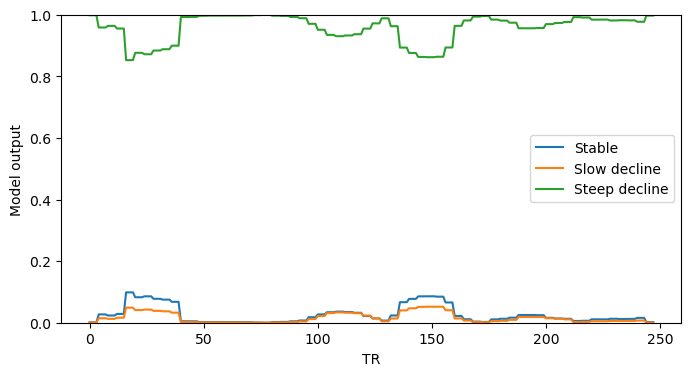

In [11]:
# TODO Tune stride and size of window
from sklearn.model_selection import GroupShuffleSplit, cross_val_score

gkf = GroupShuffleSplit(n_splits=8, random_state=1999)

cv = gkf.split(X, y, groups=centre)

scores = cross_val_score(net, X, y, cv=cv, scoring=macro_f1)
scores

  epoch    macro_f1    train_loss    valid_acc    valid_loss      dur
-------  ----------  ------------  -----------  ------------  -------
      1      0.3126        1.0798       0.6388        0.8781  12.4868
      2      0.3326        0.8739       0.5501        0.9215  12.4880
      3      0.3296        0.6667       0.6151        1.0440  12.1675
      4      0.3016        0.5993       0.4075        1.1043  12.7484
      5      0.2629        0.5607       0.3494        1.2680  12.3082
      6      0.3064        0.5370       0.6426        1.1017  12.3772
Stopping since macro_f1 has not improved in the last 5 epochs.
Restoring best model from epoch 2.
  epoch    macro_f1    train_loss    valid_acc    valid_loss      dur
-------  ----------  ------------  -----------  ------------  -------
      1      0.3309        1.0725       0.5401        0.9413  11.1103
      2      0.3399        0.8814       0.4633        0.9981  12.5877
      3      0.3081        0.6630       0.6451        1.0835  

array([0.33986708, 0.31233814, 0.31148811, 0.33541713, 0.33257862,
       0.31795853, 0.33613766, 0.3347086 ])

In [12]:
import joblib
joblib.dump(scores, run_path / "test_scores.joblib")
joblib.dump(net, run_path / "best_estimator.joblib")
metadata.to_csv(run_path / "metadata.csv")

In [13]:
net.save_params(f_params=run_path / "params.pkl")


In [ ]:

# Transformer? Size of kernel with BOLD signal?

: 

: 

: 

: 

: 

: 